In [1]:
#Restoring the previously saved mnist model

In [6]:
__author__  = 'kazem_safari'
# So here our strategy is basically the same.
# First, we load the network model. 
#Second, we initialize all the tf.global_variables in a completely separate session.
    
# Lastly, here, instead of updating them with an optimization function and
# a training loop, we update them by restoring everything from the previously saved model

import tensorflow as tf
#from tensorflow.examples.tutorials.mnist import input_data
#mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

#This module itself depends on tensorflow:
from mnist_helper_functions import param_counter, mnist_inference

tf.reset_default_graph()
#placeholders
x           = tf.placeholder(tf.float32, shape = [None, 784])
y_          = tf.placeholder(tf.float32, shape = [None, 10])
keep_prob   = tf.placeholder(tf.float32)

#reshape the input from 1D-vector to 2D-image 
x_image     = tf.reshape(x, [-1, 28, 28, 1])

#network params and hyperparams
nh_pre      = 1    #number of channels input image
nh1         = 32   #number of units first convolutional layer
nh2         = 64   #number of units second convolutional layer
nh3         = 1024 #numebr of units first fully-connected layer
num_classes = 10   #number of output classes

#building network architecture function
[y_conv, cross_entropy, correct_prediction, accuracy] = \
mnist_inference(x_image,y_, keep_prob, nh1, nh2, nh3, num_classes)
#############################################################
    ###$$$$ Here the first step is completed!
#############################################################
#here since we are restoring a pre-trained model we DONOT need the optimizer function
#with tf.name_scope('adam_optimizer'):
#    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

##########################################################
###########################################################
#This intermediate step is crucial:

    #i) instantiating an inti tensor
    # Add the variable initializer Op.
init         = tf.global_variables_initializer()        

    #ii) redefining a new instance of a sever object in tensorflow
    # Create a saver.
saver        = tf.train.Saver()
###########################################################
###########################################################

# path where the results of training are saved
model_path   = 'mnist_trad/mnist_trad.ckpt' 
save_path    = model_path

sess = tf.InteractiveSession()
#with tf.Session() as sess:
####################################################
####################################################
sess.run(init) 
###$$$$ Here the second step is completed!
####################################################
####################################################


####################################################
####################################################
saver.restore(sess, model_path)
print("Model restored from file: %s" % save_path)
###$$$$ Here the last step is completed!

#One key thing to remember, based on what i
#have read and what a ta had told me, is that, 
#to restore a model completely,
#so that no part of our model would be missing,
#we need to access all these files simultaneously:
#####################
#mnist_trad.ckpt.meta
#mnist_trad.ckpt.index
#mnist_trad.ckpt.data-00000-of-00001
#checkpoint

#And the only way which is possible to do that is
#through saver.restore(sess, model_path)
#which accesses all these file altogether!
########################
####################################################
####################################################
#mnist_trad_restore()

INFO:tensorflow:Restoring parameters from mnist_trad/mnist_trad.ckpt
Model restored from file: mnist_trad/mnist_trad.ckpt


In [7]:
#mnist_patch_occlusion_analysis

In [8]:
from tensorflow.examples.tutorials.mnist import input_data
mnist0 = input_data.read_data_sets("MNIST_data/", one_hot=False)
mnist1 = input_data.read_data_sets("MNIST_data/", one_hot=True)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from stack_occlusions import fixOcclusions_stackImages



digitClass_indicies =[]
def list_digitClass_indicies(labels0_correctly_classified):
    #here we extract the indicies of each class from labels_correctly_classified
    for i in range(10):
        digitClass = np.nonzero(labels0_correctly_classified==i)
        #print(digitclass)
        digitClass_indicies.append(digitClass)
    #print(list_digitclass_indicies)
    return digitClass_indicies

#create a list of lists to store accuracies of stack of occluded images for each digit
occu_stack_acc = [[] for _ in range(10)]
#print(occu_stack_acc)
def occlusion_accuracy_analysis(patch_size, strides, imgs_correctly_classified,
                                labels1_correctly_classified, list_digitClass_indicies):
    iter_columns = range(0, 28-patch_size[0]+strides[0], strides[0]) #iterator along columns object 
    iter_rows    = range(0, 28-patch_size[1]+strides[1], strides[1]) #iterator along rows object
    M1           = len(iter_columns)
    M2           = len(iter_rows)
    M            = M1*M2

    acc_array      = np.zeros((10,M1,M2))

    for d in range(10):
        digitClass         = digitClass_indicies[d] #get the indices of the digitclass == d
        #print(imgs_correctly_classified[digitclass].shape)
        #images_placeholder = imgs_correctly_classified[digitclass] 
        images             = imgs_correctly_classified[digitClass].reshape((-1,28,28))
        #print(images.shape)

        true_labels        = labels1_correctly_classified[digitClass] 
        #print(true_labels.shape)

        #perform occlusions
        givenOcclusions_stackImages = fixOcclusions_stackImages(images, strides, patch_size)
        #M = len(givenOcclusions_stackImages)

        #compute accuracy
        for i in range(M): #we want to eval accuracy for each (occluded) stack seperately 
            occlusion_stack             = givenOcclusions_stackImages[i] 
            occlusion_stack_placeholder = occlusion_stack.reshape((-1,784))
            acc = sess.run(accuracy, feed_dict={x:occlusion_stack_placeholder,  y_: true_labels, keep_prob: 1.0})
            occu_stack_acc[d].append(acc)
    #print(occu_stack_acc)
    for d in range(10):
        acc_array[d] = np.asarray(occu_stack_acc[d], dtype=np.float32).reshape(M1, M2)
        print("digit: %d"%d)
        print(np.around(acc_array[d], decimals = 2))
        print(2*'\n')
    return acc_array


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
N = 100
images       = mnist1.test.images[0:N]
#print(type(images))
print(images.shape)
labels0      = mnist0.test.labels[0:N] #one_hot = False
labels1      = mnist1.test.labels[0:N] #one_hot = True
print(labels1.shape)
#########################################################
### WARNING
#NEVER EVER NANME THE OUTPUT OF AN AVALUATION OF A TENSOR YOUR GRAPH TO THE NAME OF AN EXISTING
#TENSOR IN YOUR GRAPH. IT WILL CHANGE THE VALUE OF THAT TENSOR AND CAUSE HUGE PROBLEMS.
#SO, HERE WE CHOSE A DIFFERENT NAME FOR THE OUTPUT OF EVALUATIONS OF THE EXISTING TENSORS CORRECT_PREDICTION
# AND ACCURACY:
#######################################################
correct_pred, acc = sess.run([correct_prediction, accuracy],
                             feed_dict={x: images, y_: labels1, keep_prob: 1.0})
#np.set_printoptions(threshold=np.nan)
#print(correct_pred)
#print(acc)

#here we extract the correctly classified labels for occlusion analysis:
imgs_correctly_classified     = images[correct_pred.nonzero()]
labels0_correctly_classified  = labels0[correct_pred.nonzero()]
labels1_correctly_classified  = labels1[correct_pred.nonzero()]
#print(labels_correctly_classified)

digitClass_indicies = list_digitClass_indicies(labels0_correctly_classified)
strides      = [3, 3]
patch_size   = [10, 10]
acc_array    = occlusion_accuracy_analysis(patch_size, strides, imgs_correctly_classified,
                                       labels1_correctly_classified, list_digitClass_indicies)
np.save('acc_array.npy', acc_array)

(100, 784)
(100, 10)
digit: 0
[[ 1.    1.    1.    1.    1.    0.88  1.  ]
 [ 1.    1.    1.    1.    0.62  0.88  0.88]
 [ 1.    1.    1.    1.    0.75  0.75  0.88]
 [ 1.    0.75  0.88  1.    1.    0.75  0.75]
 [ 1.    0.75  0.75  1.    1.    1.    1.  ]
 [ 1.    1.    0.62  0.88  1.    1.    1.  ]
 [ 1.    1.    0.75  1.    1.    1.    1.  ]]



digit: 1
[[ 0.93  0.93  0.86  0.86  0.86  0.93  0.93]
 [ 0.93  0.93  0.71  0.57  0.57  0.79  0.93]
 [ 0.93  0.93  0.36  0.21  0.21  0.86  0.93]
 [ 0.93  0.86  0.21  0.29  0.29  0.86  0.93]
 [ 0.93  0.93  0.21  0.21  0.29  0.79  0.93]
 [ 0.93  0.93  0.29  0.14  0.07  0.71  0.93]
 [ 0.93  0.93  0.93  0.64  0.71  0.71  0.93]]



digit: 2
[[ 1.    1.    1.    1.    1.    1.    1.  ]
 [ 1.    1.    1.    1.    1.    1.    1.  ]
 [ 1.    1.    1.    1.    1.    1.    1.  ]
 [ 1.    0.75  1.    1.    1.    0.88  0.88]
 [ 1.    0.75  0.75  0.88  0.88  0.75  0.88]
 [ 1.    0.75  0.75  0.88  0.88  0.75  0.88]
 [ 1.    1.    1.    1.    1.    0.88  0.88]

In [6]:
#mnist_patch_occlusion_display

In [1]:
from stack_occlusions import fixImages_stackOcclusions
import random
#dimensions of our rectanglur moving occlusion patch


M                = 2#number of images for display
total_num_images = imgs_correctly_classified.shape[0]
print(total_num_images)
sample_indices   = random.sample(range(1,total_num_images), M)
print("sample indices: ", sample_indices)

sample_images_placeholder = imgs_correctly_classified [sample_indices]
sample_images             = imgs_correctly_classified [sample_indices].reshape((M,28,28))
print(sample_images.shape)

#patch dimensions
w = 10
h = 10

#sizes of our strides
strides2 = strides1 = 3

stack_occlusions_array = fixImages_stackOcclusions(sample_images, strides, patch_size)
#print(stack_occlusions_array.shape)

for i in range(M):
    image_stacked_occlusions = stack_occlusions_array[i]
    

NameError: name 'imgs_correctly_classified' is not defined

[[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]]
predicted label: [7]



predicted label: [7]



predicted label: [7]



predicted label: [7]



predicted label: [7]



predicted label: [7]



predicted label: [7]



predicted label: [7]



predicted label: [7]



predicted label: [7]



predicted label: [7]



predicted label: [7]



predicted label: [7]



predicted label: [7]



predicted label: [7]



predicted label: [7]



predicted label: [7]



predicted label: [7]



predicted label: [7]



predicted label: [7]



predicted label: [7]



predicted label: [7]



predicted label: [7]



predicted label: [7]



predicted label: [7]



predicted label: [7]



predicted label: [7]



predicted label: [7]



predicted label: [7]



predicted label: [7]



predicted label: [7]



predicted label: [7]



predicted label: [7]



predicted label: [7]



predicted label: [7]



predicted label: [7]



predicted label: [7]



predicted label: [7]



predicted label: [7]





/home/alleria/virtualenvs/tensorflow1.4/lib/python3.5/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


predicted label: [7]



predicted label: [7]



predicted label: [7]



predicted label: [7]



predicted label: [7]



predicted label: [7]



predicted label: [7]



predicted label: [7]



predicted label: [7]



predicted label: [7]



49


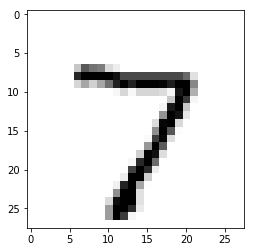

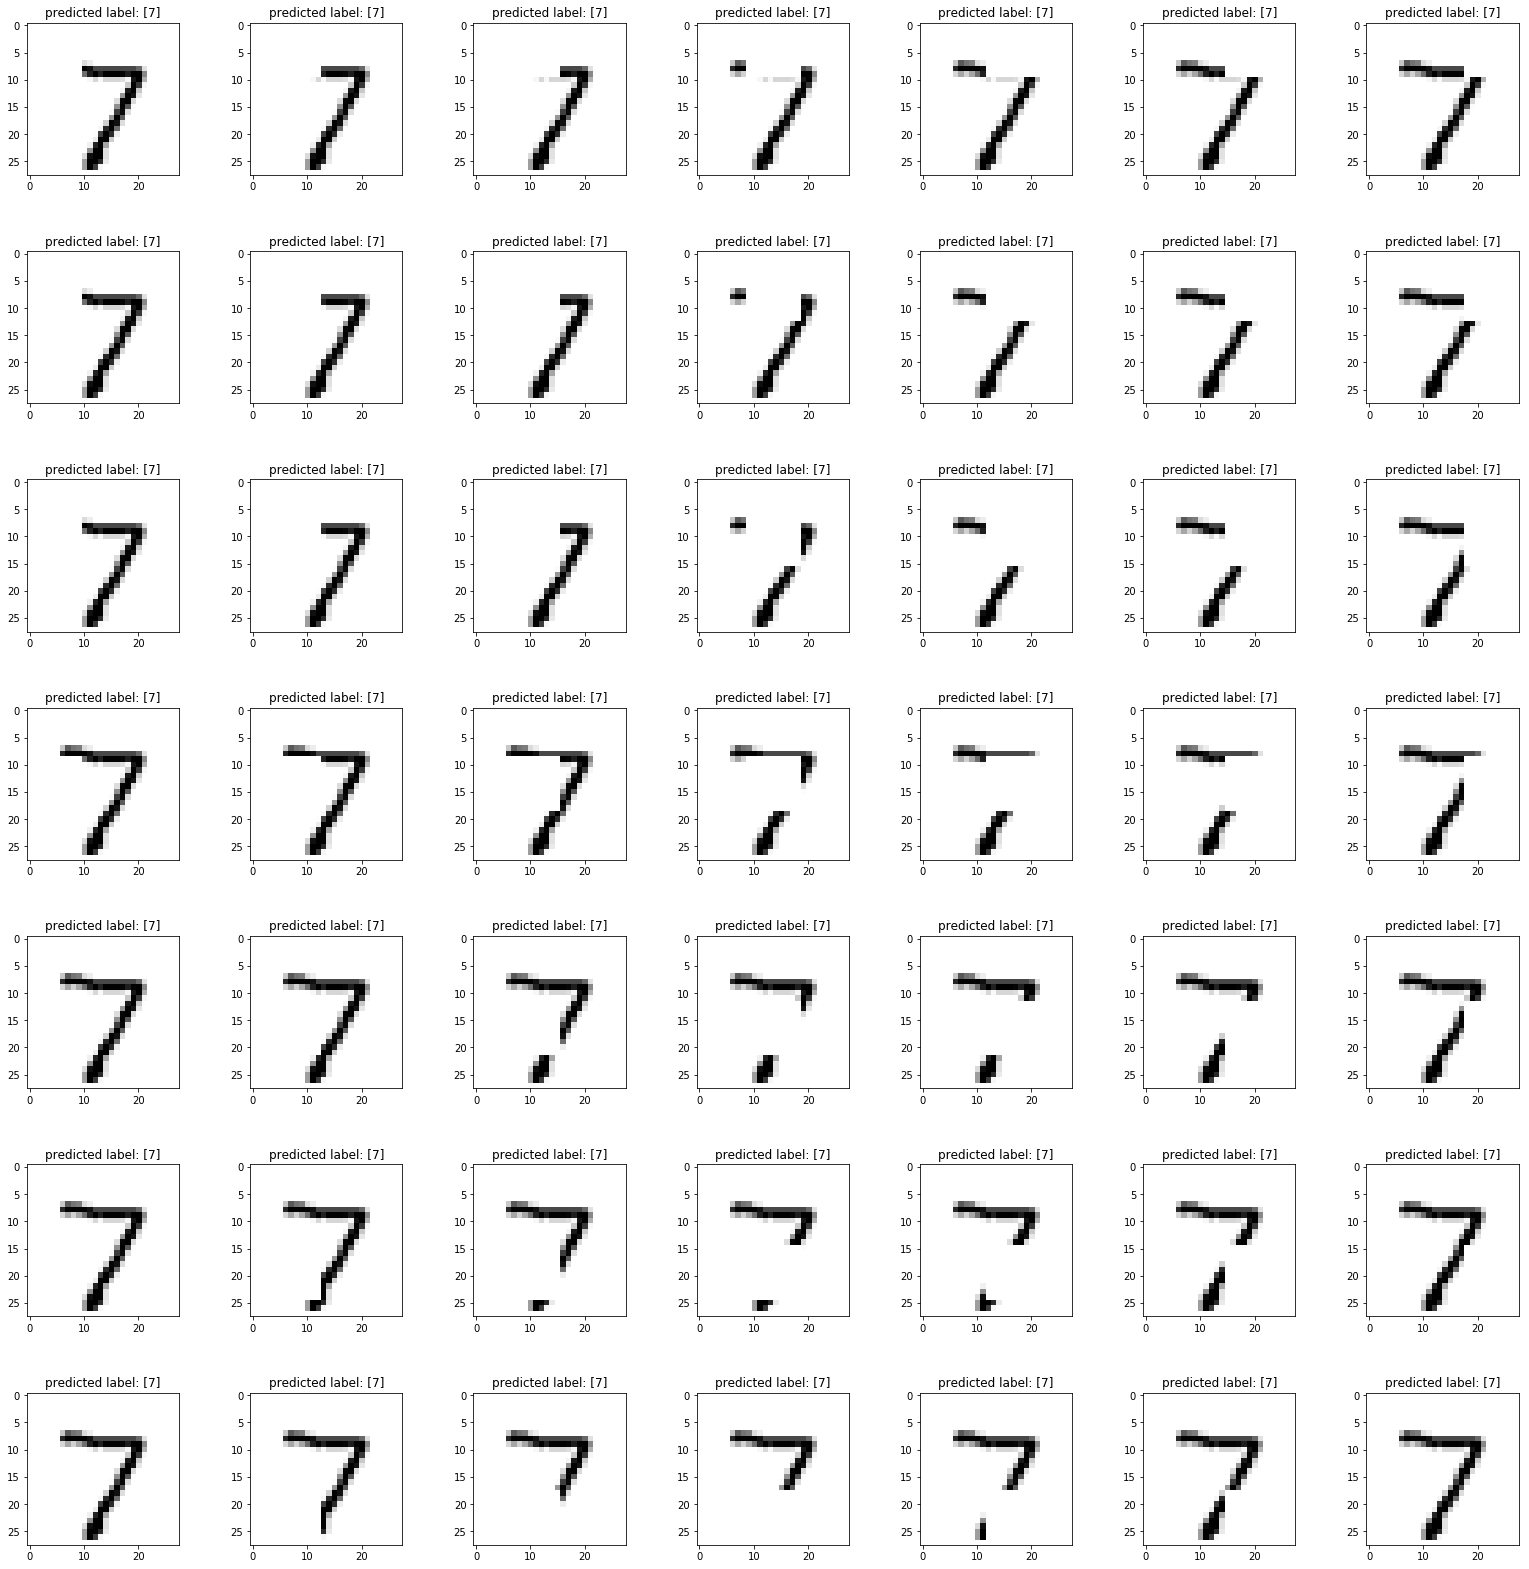

In [10]:
M=1
#patch dimensions
w = 10
h = 10

#sizes of our strides
strides2 = strides1 = 3

for k in range(M):
    # a sample image and label
    img_placeholder   = imgs_correctly_classified[k].reshape((1,784)) #k is the iterable
    img               = img_placeholder.reshape(28,28) 
    plt.imshow(img, cmap='Greys')
    
    sample_label0     = labels0_correctly_classified [k] #k is the iterable
    sample_label1     = labels1_correctly_classified [k] #k is the iterable
    
    img_placeholder   = img.reshape((1,784))
    label_placeholder = sample_label1.reshape((1,10))
    print(label_placeholder)
    #true_label        = np.argmax(label_placeholder, axis=1)
    #print("true accuracy: ", sess.run(accuracy, feed_dict={x:img_placeholder, y_:label_placeholder, keep_prob: 1.0}))

    #########################################
    #previous strategy!
    # we aim to occlude only the nonzero portion of the image which contains essential information
    #print(img.nonzero())
    #max_r = np.max(img.nonzero(), axis = 1)[0]
    #max_c = np.max(img.nonzero(), axis = 1)[1]
    #min_r = np.min(img.nonzero(), axis = 1)[0]
    #min_c = np.min(img.nonzero(), axis = 1)[1]
    # range objects for performing iterations in for loops
    #iter_columns    = range(min_r,max_r-w+strides1, strides1)
    #iter_rows       = range(min_c, max_c-h+strides2, strides2)
    ############################################


    ################################################
    ##################################################
    #Our new strategy
    iter_columns = range(0,28-w+strides1,strides1)
    iter_rows    = range(0,28-h+strides2, strides2)
    ##############################################
    ################################################

    #total number of possible occlusions in each dimension 
    num_rows     = len(iter_columns)
    num_columns  = len(iter_rows) 



    # plotting figures of occluded image
    fig, axs = plt.subplots(num_rows,num_columns, figsize=(28, 28))
    fig.subplots_adjust(hspace = .5, wspace=.001)

    axs = axs.ravel()
    index = 0
    #axs[index].imshow(sample_image, cmap='Greys')
    #axs[index].set_title("true label "+ str(true_label))
    #index +=1

    for i in iter_columns:
        for j in iter_rows:

            occluded_img = img.copy()
            if i == iter_columns[-1]:
                occluded_img[i:-1, j:j+h] = 0
                #print(range(i, -1), range(j, j+h))
            
            elif j == iter_rows[-1]:
                occluded_img[i:i+w, j:-1] = 0
                #print(range(i, i+w), range(j,-1))

            else:
                occluded_img[i:i+w, j:j+h] = 0
                #print(range(i, i+w), range(j,j+w))
                
            occluded_img_placeholder = occluded_img.reshape((1,784))
            fig = plt.figure()

            #label_placeholder is the same as the label_placeholder for the original image 
            net_output      = sess.run(y_conv, 
                                 feed_dict={x:occluded_img_placeholder, y_:label_placeholder, keep_prob: 1.0})
            #print(net_output)
            #probs           = sess.run((tf.nn.softmax(net_output)))
            #print(probs)
            perdicted_label = np.argmax(net_output, axis=1)
            print("predicted label:", perdicted_label)
            #print("accuracy:", acc)
            print(2*'\n')


            axs[index].imshow(occluded_img, cmap='Greys')
            axs[index].set_title("predicted label: "+ str(perdicted_label))
            index +=1
    print(index)